## Fashion MNIST

My attempt at creating a single-layer neural network with numpy only and training it to the best possible accuracy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path

In [4]:
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')
X = train_data.drop('label', axis=1).to_numpy()
Y = train_data['label'].to_numpy()
X_test = test_data.drop('label', axis=1).to_numpy()
Y_test = test_data['label'].to_numpy()

### Attempt 1: Simple network with sigmoid and MSE loss (no regularization)
With batch_size 15 and learning rates starting from 0.1 (that I decreased over multiple runs...), I could achieve a maximum accuracy of 79.5%

In [ ]:
class Network:
    def __init__(self, n_hidden, learning_rate, batch_size, lamda, start_params = None):
        if start_params is None:
            self.w1 = np.random.randn(n_hidden, 784)
            self.b1 = np.random.randn(n_hidden, 1)
            self.w2 = np.random.randn(10, n_hidden)
            self.b2 = np.random.randn(10, 1)
        else:
            (self.w1, self.w2, self.b1, self.b2) = start_params

        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.lamda = lamda
        self.epochs = 0
    
    def forward(self, x):
        z1 = self.w1 @ x + self.b1
        a1 = self.sigmoid(z1)
        z2 = self.w2 @ a1 + self.b2
        a2 = self.sigmoid(z2)
        return z1, a1, z2, a2

    def y_to_vec(self, y):
        # assuming y is (n, 1)
        new_y = []
        for n in y:
            new_row = [1 if n == i else 0 for i in range(10)]
            new_y.append(new_row)
        return np.array(new_y)

    def forward_simple(self, x):
        return self.sigmoid(self.w2 @ self.sigmoid(self.w1 @ x + self.b1) + self.b2)
    
    def test_loss(self, x_test, y_test):
        xt = x_test.T
        yt = self.y_to_vec(y_test).T
        return ((self.forward_simple(xt) - yt) ** 2).flatten().mean()
    
    def test_accuracy(self, xt, yt):
        xt = xt.T
        yt = yt.T
        res = np.argmax(self.forward_simple(xt), axis=0)
        unique, counts = np.unique(yt == res, return_counts=True)
        d = dict(zip(unique, counts))
        return (d[0], d[1])
    
    def train(self, epochs, x, y, x_t, y_t):
        # each training example is a row!
        n = x.shape[0]
        accuracies = []
        mse_vals = []
        for ep in range(epochs):
            idx = np.arange(n)
            np.random.shuffle(idx)
            x = x[idx]
            y = y[idx]

            losses = []
            for i in range(0, n, self.batch_size):
                xb = x[i:i + self.batch_size]
                yb = y[i:i + self.batch_size]
                loss = self.process_batch(xb, yb)
                losses.append(loss)
            
            mse = sum(losses) / (n // self.batch_size)
            # test_mse = self.test_loss(x_t, y_t)
            d0, d1 = self.test_accuracy(x_t, y_t)
            accuracies.append(d1 / x_t.shape[0])
            mse_vals.append(mse)
            print(f'{ep}: {round(mse, 4)}  {d1}/{x_t.shape[0]}')
            self.epochs += 1
        return mse_vals, accuracies
    
    def process_batch(self, x, y):
        # we want this to be (784, n)
        x = x.T
        y = self.y_to_vec(y).T
        assert x.shape[0] == 784 and y.shape[0] == 10
        dw1 = np.zeros(self.w1.shape)
        dw2 = np.zeros(self.w2.shape)
        db1 = np.zeros(self.b1.shape)
        db2 = np.zeros(self.b2.shape)

        for i in range(self.batch_size):
            xx = x[:,i].copy().reshape(-1,1)
            yy = y[:,i].copy().reshape(-1,1)
            z1, a1, z2, a2 = self.forward(xx)
            delta2 = (a2 - yy) * self.sigmoid_derivative(z2)
            delta1 = (self.w2.T @ delta2) * self.sigmoid_derivative(z1)
            dw1 += np.outer(delta1, xx) / self.batch_size
            dw2 += np.outer(delta2, a1) / self.batch_size
            db1 += delta1 / self.batch_size
            db2 += delta2 / self.batch_size

        self.w1 = self.w1 * (1 - self.lamda) - self.learning_rate * dw1
        self.w2 = self.w2 * (1 - self.lamda) - self.learning_rate * dw2
        self.b1 -= self.learning_rate * db1
        self.b2 -= self.learning_rate * db2

        # return MSE
        return ((a2 - y)**2).flatten().sum() / self.batch_size / 10
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

In [ ]:
n = Network(100, 0.0005, 50, 0.0)
if Path('network1.pkl').is_file():
    with open('network1.pkl', 'rb') as file:
        n = pickle.load(file)
mse, acc = n.train(100, X, Y, X_test, Y_test)

In [ ]:
# Run this cell if you have got a satisfactory rate and want to lock in future runs
with open('network1.pkl', 'wb') as file:
    pickle.dump(n, file)

I also tried with some L2 regularisation but didn't get satisfactory results.

## Part 2: Building the nwtwork with pytorch

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
# Downloading the data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)
print(f'Train data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

Train data size: 60000
Test data size: 10000


In [39]:
def init_network(n_hidden, learning_rate):
    model = torch.nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, n_hidden),
        nn.Sigmoid(),
        nn.Linear(n_hidden, 10),
        nn.Sigmoid(),
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    return model, optimizer, loss_fn

def train_model(train_data, test_data, model, loss_fn, optimizer, batch_size, epochs=100):
    # A DataLoader handles shuffling and dividing mini batches while training with good performance
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_loss = []
    test_accuracy = []
    
    for ep in range(epochs):
        loss_val = 0
        # training
        for x, y in train_dataloader:
            # print(x.shape, y.shape, model(x).shape)
            # print(y)
            optimizer.zero_grad()
            pred = model(x)
            
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            loss_val += loss.data.item() / batch_size
        avg_loss = loss_val / len(train_dataloader)
        train_loss.append(avg_loss)
        
        # finding accuracy:
        correct = 0
        for x, y in test_dataloader:
            pred_t = model(x)
            label = torch.argmax(pred_t, 1)
            correct += (label == y).sum().item()
        accuracy = correct / len(test_data)
        test_accuracy.append(accuracy)
        print(f'{ep}: {round(avg_loss, 4)} --- {round(accuracy, 2)}')
    return train_loss, test_accuracy

0: 0.0271 --- 0.52
1: 0.0259 --- 0.51
2: 0.0257 --- 0.52
3: 0.0255 --- 0.55
4: 0.0254 --- 0.55
5: 0.0254 --- 0.58
6: 0.0253 --- 0.62
7: 0.0251 --- 0.72
8: 0.025 --- 0.72
9: 0.0249 --- 0.75
10: 0.0248 --- 0.78
11: 0.0248 --- 0.78
12: 0.0247 --- 0.81
13: 0.0247 --- 0.83
14: 0.0245 --- 0.83
15: 0.0244 --- 0.84
16: 0.0244 --- 0.84
17: 0.0243 --- 0.84
18: 0.0243 --- 0.84
19: 0.0243 --- 0.84
20: 0.0243 --- 0.84
21: 0.0242 --- 0.85
22: 0.0242 --- 0.85
23: 0.0242 --- 0.85
24: 0.0242 --- 0.85
25: 0.0242 --- 0.85
26: 0.0242 --- 0.85
27: 0.0242 --- 0.85
28: 0.0241 --- 0.85
29: 0.0241 --- 0.85
30: 0.0241 --- 0.85
31: 0.0241 --- 0.85
32: 0.0241 --- 0.85
33: 0.0241 --- 0.85
34: 0.0241 --- 0.86
35: 0.0241 --- 0.86
36: 0.0241 --- 0.86
37: 0.024 --- 0.86
38: 0.024 --- 0.86
39: 0.024 --- 0.86
40: 0.024 --- 0.86
41: 0.024 --- 0.86
42: 0.024 --- 0.86
43: 0.024 --- 0.85
44: 0.024 --- 0.86
45: 0.024 --- 0.87
46: 0.024 --- 0.86
47: 0.024 --- 0.86
48: 0.024 --- 0.86
49: 0.0239 --- 0.87
0: 0.0239 --- 0.86
1: 0

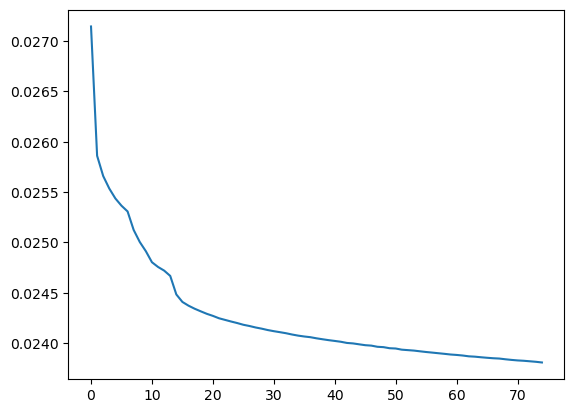

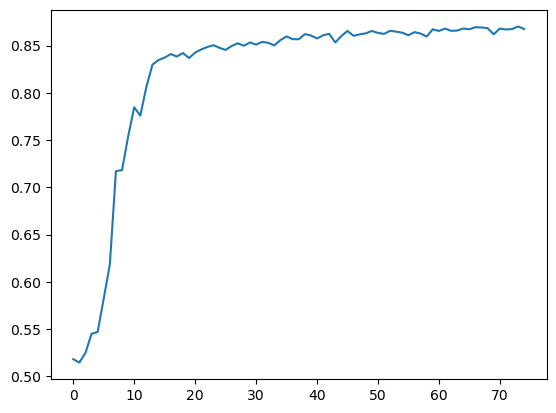

In [46]:
model, optimizer, loss_fn = init_network(256, 1)
tr_loss, accuracy = train_model(train_data, test_data, model, loss_fn, optimizer, 64, 50)
# now we train some more epochs with a slower learning rate (this is a sort of manual rate scheduling)
optimiser = torch.optim.SGD(model.parameters(), lr=0.1)
tr_loss2, accuracy2 = train_model(train_data, test_data, model, loss_fn, optimizer, 64, 25)
tr_loss += tr_loss2
accuracy += accuracy2

plt.plot(tr_loss)
plt.show()
plt.plot(accuracy)
plt.show()

The above network maxes out at 87% accuracy which is much better than the last one.